# Classification fine-tuning BERT

Inspired from [this other notebook](https://github.com/Dani-Mora/bernie-vs-trump-bert-fine-tuning/blob/master/bert_classification_fine_tuning.ipynb).

In [1]:
import os
import json
from typing import Tuple
import yaml

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import numpy as np

import pandas as pd
pd.set_option('display.max_colwidth', None)

import seaborn as sns

import torch
from torch.utils.data import (
    TensorDataset,
    DataLoader
)

from ignite.metrics import Fbeta
from ignite.engine import (
    Events,
    Engine,
)

## Load BERT tokenizer

In [2]:
pretrained_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

## Read data

In [3]:
train_df = pd.read_csv(os.path.join('data', 'train.csv'))

## Visualize token length

In [4]:
positive_token_ids = train_df[train_df.target == 1].text.apply(
    lambda x: tokenizer.encode(str(x), add_special_tokens=False)
)

negative_token_ids = train_df[train_df.target == 0].text.apply(
    lambda x: tokenizer.encode(str(x), add_special_tokens=False)
)

Plot both distributions.

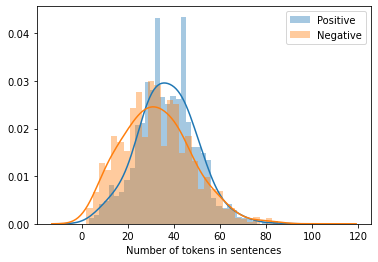

In [5]:
ax = sns.distplot(
    list(map(len, positive_token_ids)),
         hist=True,
         kde=True,
         norm_hist=True,
         kde_kws={'bw': 5},
         label='Positive',
         axlabel='Number of tokens in sentences',
)

sns.distplot(
    list(map(len, negative_token_ids)),
         hist=True,
         kde=True,
         norm_hist=True,
         ax=ax,
         label='Negative',
         kde_kws={'bw': 5},
)

ax.legend()

We see positive instances tend to be larger. Let's set the maximum sentence length to 60 characters.

In [6]:
max_token_num = 60

## Load pre-trained model

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Split training-validation data

In [8]:
training_df, validation_df = train_test_split(train_df,
                                              test_size=0.15,
                                              stratify=train_df.target)

## Load datasets using BERT output

In [9]:
def encode_sentence(text: str, max_length: int) -> Tuple[np.ndarray, np.ndarray]:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask = True
    )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']


def process_data(df: pd.DataFrame,
                 max_length: int) -> Tuple[np.ndarray,
                                           np.ndarray,
                                           np.ndarray]:
    """ Map sentences in DataFrame into proper model inputs
    
    We are extracting, for each sentence:
    
        - List of token identifiers (including special tokens)
        - Input attention masks (which prevent focusing on padding tokens)
        - Sentence label
        
    Number of tokens are padded to the maximum provided (special
    tokens are considered for computing the length of the sentence).
    
    """
    encoded_dicts = df.text.apply(
        lambda x: encode_sentence(x, max_length=max_length)
    )
    token_ids, attention_masks = zip(*encoded_dicts)
    return token_ids, attention_masks, df.target.values


def build_dataset(df: pd.DataFrame,
                  max_length: int) -> torch.utils.data.Dataset:
    token_ids, attention_masks, labels = process_data(df,
                                                      max_length=max_length)
    return TensorDataset(torch.Tensor(token_ids).to(torch.long),
                         torch.Tensor(attention_masks),
                         torch.Tensor(labels).to(torch.long))

# As dataset is small, we can fit it on memory
train_dataset = build_dataset(training_df, max_length=max_token_num)
val_dataset = build_dataset(validation_df, max_length=max_token_num)

## Load experiment parameters

In [10]:
with open("params.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

## Training

In [11]:
batch_size = params['batch_size']
optimizer = AdamW(model.parameters(), lr = params['lr'])  # integrated LR decay
n_epochs = params['n_epochs']

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

Define train step.

In [12]:
def train_step(engine, batch):

    model.train()
    
    optimizer.zero_grad()
    
    batch_token_ids = batch[0].to(device)
    batch_att_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)
    
    loss, _ = model(batch_token_ids,
                    attention_mask=batch_att_masks, 
                    labels=batch_labels)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

Define validation step.

In [13]:
def validation_step(engine, batch):
    
    model.eval()
    
    with torch.no_grad():
        
        batch_token_ids = batch[0].to(device)
        batch_att_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        batch_logits = model(batch_token_ids, attention_mask=batch_att_masks)
        return batch_logits[0], batch_labels

Create training and validation engines.

In [14]:
trainer = Engine(train_step)

evaluator = Engine(validation_step)
fbeta = Fbeta(beta=1.0, average=True)
fbeta.attach(evaluator, 'f1_score')

Define callbacks.

In [15]:
@trainer.on(Events.ITERATION_COMPLETED(every=15))
def log_training_loss(trainer):
    iteration = trainer.state.iteration
    n_iterations = trainer.state.epoch_length
    print(
        f'Epoch[{trainer.state.epoch}/{trainer.state.max_epochs}] '
        f'Iteration[{(iteration - 1) % n_iterations}/{n_iterations}] '
        f'Loss: {trainer.state.output:.2f}'
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f'Training Results - Epoch: {trainer.state.epoch}, '
          f'F1 score: {metrics["f1_score"]:.2f}')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f'Validation Results - Epoch: {trainer.state.epoch}, '
          f'F1 score: {metrics["f1_score"]:.2f}')

Start training.

In [16]:
history = trainer.run(train_loader, max_epochs=n_epochs);

Epoch[1/5] Iteration[14/86] Loss: 0.74


Epoch[1/5] Iteration[29/86] Loss: 0.59


Epoch[1/5] Iteration[44/86] Loss: 0.64


Epoch[1/5] Iteration[59/86] Loss: 0.48


Epoch[1/5] Iteration[74/86] Loss: 0.47


Training Results - Epoch: 1, F1 score: 0.81


Validation Results - Epoch: 1, F1 score: 0.79


Epoch[2/5] Iteration[3/86] Loss: 0.40


Epoch[2/5] Iteration[18/86] Loss: 0.48


Epoch[2/5] Iteration[33/86] Loss: 0.41


Epoch[2/5] Iteration[48/86] Loss: 0.39


Epoch[2/5] Iteration[63/86] Loss: 0.36


Epoch[2/5] Iteration[78/86] Loss: 0.52


Training Results - Epoch: 2, F1 score: 0.87


Validation Results - Epoch: 2, F1 score: 0.80


Epoch[3/5] Iteration[7/86] Loss: 0.43


Epoch[3/5] Iteration[22/86] Loss: 0.34


Epoch[3/5] Iteration[37/86] Loss: 0.39


Epoch[3/5] Iteration[52/86] Loss: 0.56


Epoch[3/5] Iteration[67/86] Loss: 0.33


Epoch[3/5] Iteration[82/86] Loss: 0.18


Training Results - Epoch: 3, F1 score: 0.91


Validation Results - Epoch: 3, F1 score: 0.82


Epoch[4/5] Iteration[11/86] Loss: 0.28


Epoch[4/5] Iteration[26/86] Loss: 0.32


Epoch[4/5] Iteration[41/86] Loss: 0.27


Epoch[4/5] Iteration[56/86] Loss: 0.27


Epoch[4/5] Iteration[71/86] Loss: 0.32


Training Results - Epoch: 4, F1 score: 0.94


Validation Results - Epoch: 4, F1 score: 0.82


Epoch[5/5] Iteration[0/86] Loss: 0.28


Epoch[5/5] Iteration[15/86] Loss: 0.43


Epoch[5/5] Iteration[30/86] Loss: 0.27


Epoch[5/5] Iteration[45/86] Loss: 0.15


Epoch[5/5] Iteration[60/86] Loss: 0.33


Epoch[5/5] Iteration[75/86] Loss: 0.23


Training Results - Epoch: 5, F1 score: 0.95


Validation Results - Epoch: 5, F1 score: 0.81


In [17]:
evaluator.run(train_loader)
train_metrics = evaluator.state.metrics.copy()
evaluator.run(val_loader)
val_metrics = evaluator.state.metrics.copy()

## Evaluate test

In [18]:
test_df = pd.read_csv(os.path.join('data', 'test.csv'))
test_dataset = build_dataset(test_df, max_length=max_token_num)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
evaluator.run(test_loader)
test_metrics = evaluator.state.metrics.copy()

## Store metrics training metrics

In [19]:
with open('train_metrics.json', 'w') as f:
    json.dump({'f1_macro': train_metrics['f1_score']}, f)

with open('val_metrics.json', 'w') as f:
    json.dump({'f1_macro': val_metrics['f1_score']}, f)
    
with open('test_metrics.json', 'w') as f:
    json.dump({'f1_macro': test_metrics['f1_score']}, f)